In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 'large'
new_rc_params = {'text.usetex': False,
'font.sans-serif': 'Arial'
}
mpl.rcParams.update(new_rc_params)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# https://stackoverflow.com/a/18926541/12649
import matplotlib.colors as colors
import matplotlib.patches as patches

prop_cycle = plt.rcParams['axes.prop_cycle']
colorss = prop_cycle.by_key()['color']

import os
import gzip
import pickle

import numpy as np
import random
from scipy.stats import ttest_ind

from simrecorder import ZarrDataStore

# Load data

In [2]:
dpath = '/calc/ceca/output/Strings-OH/alif-89596-D22-10-2019-T09-06-46/results'
dpath_test = dpath

hd = ZarrDataStore(os.path.join(dpath, 'data.mdb'))
hd_test = ZarrDataStore(os.path.join(dpath_test, 'data.mdb'))

In [3]:
test_input_spikes = hd_test.get_all('test/input')
test_input_analog = hd_test.get_all('test/input_analog')
test_targets = hd_test.get_all('test/target')

test_output = hd_test.get_all('test/actual_output')
test_all_probs = hd_test.get_all('test/all_probs')
states = hd_test.get_all('test/states')
print(test_input_spikes.shape, test_input_analog.shape, test_targets.shape)
print(test_output.shape, test_all_probs.shape, states.shape)

(1000, 50, 6000, 175) (1000, 50, 12, 35) (1000, 50, 6, 32)
(1000, 50, 6) (1000, 50, 12, 32) (1000, 50, 6000, 320)


In [4]:
n_iter = test_input_analog.shape[0]
n_ep = test_input_analog.shape[1]
n_steps = 5 
num_neurons = states.shape[-1]
num_symbols = 31 # Letter-symbols with indices 0-30
steps_ms = 500

In [5]:
episodes = np.argmax(test_input_analog[:, :, :5, :], axis=-1)
print(episodes.shape)

(1000, 50, 5)


In [6]:
ind_id = (test_input_analog[:, :, 0, -2] == 1)
print(ind_id.shape)
num_id_episodes = np.sum(ind_id)
print(num_id_episodes)

ind_rev = (test_input_analog[:, :, 0, -1] == 1)
print(ind_rev.shape)
num_rev_episodes = np.sum(ind_rev)
print(num_rev_episodes)

(1000, 50)
25007
(1000, 50)
24993


In [7]:
# Read in spike_counts, OR calculate them and save them (next cell)
with open(os.path.join(dpath, 'spike_counts.pkl'), 'rb') as f:
    spike_counts = pickle.load(f) 
print(spike_counts.shape)       

(1000, 50, 5, 320)


In [9]:
# sl = 100
# bt = 50
# nn = 320
# nit = 1000

# spike_counts = np.empty((nit, bt, 5, nn))
# for i in range(0, nit, sl):
#     print("Running for indices from %d to %d" % (i , i + sl))
#     arr = states[i:(i+sl), :, :5*steps_ms, :].reshape(sl, bt, 5, steps_ms, nn)
#     spike_counts[i:(i+sl), ...] = np.sum(arr, axis=3)
    
# print(spike_counts.shape)
# with open(os.path.join(dpath, 'spike_counts.pkl'), 'wb') as f:
#     pickle.dump(spike_counts, f)

Running for indices from 0 to 100
Running for indices from 100 to 200
Running for indices from 200 to 300
Running for indices from 300 to 400
Running for indices from 400 to 500
Running for indices from 500 to 600
Running for indices from 600 to 700
Running for indices from 700 to 800
Running for indices from 800 to 900
Running for indices from 900 to 1000
(1000, 50, 5, 320)


In [8]:
id_ep = np.tile(ind_id[:, :, None, None], (1, 1, 5, 320))
id_spks = spike_counts[id_ep].reshape(-1, 5, 320)
print(id_spks.shape)

(25007, 5, 320)


In [9]:
rev_ep = np.tile(ind_rev[:, :, None, None], (1, 1, 5, 320))
rev_spks = spike_counts[rev_ep].reshape(-1, 5, 320)
print(rev_spks.shape)

(24993, 5, 320)


In [10]:
spike_counts.shape

(1000, 50, 5, 320)

# Three-way ANOVA

In [11]:
import pingouin as pg

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [12]:
# Load spikes_counts, and discard neurons with FR < 2Hz and > 60Hz
with open(os.path.join(dpath, 'spike_counts.pkl'), 'rb') as f:
    spike_counts = pickle.load(f) 
print(spike_counts.shape)

spike_counts_tmp = spike_counts.reshape((-1, 5, 320))
print(spike_counts_tmp.shape)

mean_spk_cnts = np.mean(spike_counts_tmp, axis=1)
print(mean_spk_cnts.shape)

mean_spk_fr = mean_spk_cnts / 0.5
mean_spk_fr_per_neuron = np.mean(mean_spk_fr, axis=0)
print(mean_spk_fr_per_neuron.shape)

ind_neurons = np.logical_and(mean_spk_fr_per_neuron >= 2, mean_spk_fr_per_neuron <= 60)
# ind_neurons = mean_spk_fr_per_neuron >= 2
print(ind_neurons.shape, np.sum(ind_neurons))

lst_neurons = list(np.where(ind_neurons == True)[0]) # neurons after discarding the outliers
# print(lst_neurons)

(1000, 50, 5, 320)
(50000, 5, 320)
(50000, 320)
(320,)
(320,) 279


In [13]:
task_id = test_input_analog[:, :, 0, -2:]
task_id = task_id.reshape((-1, 2))
task_idx = np.argmax(task_id, axis=1)

num_ep = spike_counts.shape[0] * spike_counts.shape[1]
all_episodes = episodes.reshape((num_ep, 5))

print(task_id.shape)
print(num_ep)

(50000, 2)
50000


161.29032258064515 135 196


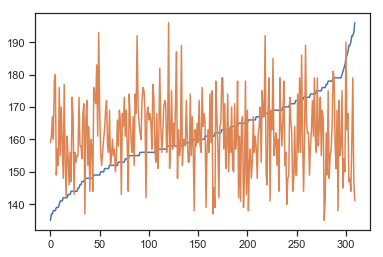

In [14]:
# Generate "balanced" test set
random.seed(3000)
np.random.seed(3000)

gen_again = True
while gen_again:
    rnd_pos = np.random.randint(5, size=num_ep)
    sym_rnd_steps = all_episodes[np.arange(num_ep), rnd_pos]
    
    code_dct = {}
    for i in range(num_ep):
        seq = [task_idx[i], rnd_pos[i], sym_rnd_steps[i]]
        str_seq = '.'.join([str(int(x)) for x in seq])
        if str_seq in code_dct:
            code_dct[str_seq] += 1
        else:
            code_dct[str_seq] = 1

    dct_vals = list(code_dct.values())
    
    if np.max(dct_vals) - np.min(dct_vals) <= 62:
        gen_again = False
        print(np.mean(dct_vals), np.min(dct_vals), np.max(dct_vals))

mn = np.min(dct_vals)

fig = plt.plot(np.sort(dct_vals))
fig = plt.plot(dct_vals)

In [15]:
mn = np.min(dct_vals)
sym_rnd_steps = all_episodes[np.arange(num_ep), rnd_pos]

cnt_dct = {}
dp_to_take = np.ones((num_ep, ), dtype=bool) # Datapoints to take
for i in range(num_ep):
    seq = [task_idx[i], rnd_pos[i], sym_rnd_steps[i]]
    str_seq = '.'.join([str(int(x)) for x in seq])
    if str_seq in cnt_dct:
        cnt_dct[str_seq] += 1
    else:
        cnt_dct[str_seq] = 1
    
    if cnt_dct[str_seq] > mn:
        dp_to_take[i] = False
assert np.sum(dp_to_take) == 2 * 5 * 31 * mn
print('Number of examples per condition used: ', mn)

Number of examples per condition used:  135


In [16]:
results_neuron = np.zeros((320, 8, 4))
rest_of_results_neuron = np.zeros((320, 8, 4))

tmp_rates = spike_counts.reshape(-1, 5, 320)
sym_rnd_steps = all_episodes[dp_to_take, rnd_pos[dp_to_take]]

for neuron_i in lst_neurons:
    tmp_rates_neur = tmp_rates[:, :, neuron_i]
    tmp_rates_rnd_steps = tmp_rates_neur[dp_to_take, rnd_pos[dp_to_take]]
    
    df = pd.DataFrame({"Task": task_idx[dp_to_take],
                       "Position": rnd_pos[dp_to_take], 
                       "Symbol": sym_rnd_steps, 
                       "Rates": tmp_rates_rnd_steps})
    
    aov = df.anova(dv='Rates', between=['Task', 'Position', 'Symbol'], ss_type=2)
    aov['eta_sq'] = aov[:-1]['SS']/sum(aov['SS'])
    aov['omega_sq'] = (aov[:-1]['SS']-(aov[:-1]['DF']*aov['MS'][7]))/(sum(aov['SS'])+aov['MS'][7])
    label_list = [str(neuron_i), str(neuron_i), str(neuron_i), str(neuron_i), 
                  str(neuron_i), str(neuron_i), str(neuron_i), str(neuron_i)]
    aov['neuron_idx'] = label_list
        
    results_neuron[neuron_i, :, 0] = aov['F']
    results_neuron[neuron_i, :, 1] = aov['p-unc']
    results_neuron[neuron_i, :, 2] = aov['eta_sq']
    results_neuron[neuron_i, :, 3] = aov['omega_sq']
    
    rest_of_results_neuron[neuron_i, :, 0] = aov['SS']
    rest_of_results_neuron[neuron_i, :, 1] = aov['DF']
    rest_of_results_neuron[neuron_i, :, 2] = aov['MS']
    rest_of_results_neuron[neuron_i, :, 3] = aov['np2']

In [17]:
task_idx[dp_to_take].shape, rnd_pos[dp_to_take].shape, sym_rnd_steps.shape, tmp_rates_rnd_steps.shape

((41850,), (41850,), (41850,), (41850,))

In [18]:
aov # table for the last neuron that was analyzed

,Source,SS,DF,MS,F,p-unc,np2,eta_sq,omega_sq,neuron_idx
0,Task,4397.523,1.0,4397.523,420.935,4.426979e-93,0.010,0.000157,0.000157,319
1,Position,3713694.898,4.0,928423.725,88869.596,0.000000e+00,0.895,0.132707,0.132706,319
2,Symbol,8866272.495,30.0,295542.416,28289.599,0.000000e+00,0.953,0.316833,0.316821,319
3,Task * Position,3061954.096,4.0,765488.524,73273.285,0.000000e+00,0.876,0.109418,0.109416,319
4,Task * Symbol,15403.179,30.0,513.439,49.147,2.464928e-286,0.034,0.000550,0.000539,319
5,Position * Symbol,6777976.414,120.0,56483.137,5406.619,0.000000e+00,0.940,0.242208,0.242163,319
6,Task * Position * Symbol,5110409.142,120.0,42586.743,4076.443,0.000000e+00,0.922,0.182618,0.182574,319
7,Residual,433969.807,41540.0,10.447,NaN,NaN,NaN,NaN,NaN,319


In [19]:
# Maximum omega_sq per category and the neuron for which it is the case
tmp = results_neuron[:, :-1, 3] # omega_sq for each neuron, and each category (see the rows of aov table)
print(tmp.shape)

for i in range(7): # 7 out of 8 rows in aov table, discarding the row "Residuals" 
    print(np.max(tmp[:, i]), np.argmax(tmp[:, i]))

(320, 7)
0.14743054961016325 14
0.9075644528930873 97
0.9432165741371948 121
0.6784993176437883 253
0.07167002746752539 30
0.5310694726867291 206
0.4370244049327183 7


# Count per category

Num. neurons with no category:  0
[  1.  89. 228. 136.   0. 169. 237.]


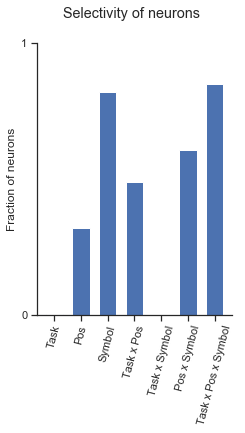

In [20]:
# Count neurons multiple times
cat_of_neurons = -1 * np.ones((320, ))
categories = np.zeros((7, ))
lst_no_cat = []
col = 3  # omega_sq

for i in lst_neurons:
    categorized = False
    for cat in range(7):
        if results_neuron[i, cat, 1] < 0.001 and results_neuron[i, cat, col] >= 0.14:
            categories[cat] += 1
            categorized = True
            cat_of_neurons[i] = cat
    if categorized == False:
        lst_no_cat.append(i)

print('Num. neurons with no category: ', len(lst_no_cat))
print(categories)

##################### Histogram ############################
fig, ax = plt.subplots(1, 1, figsize=(3.5, 5.0))
plt.suptitle('Selectivity of neurons')
xx = np.linspace(0, 7, 7)

ax.bar(x=xx, height=categories/len(lst_neurons), width=0.75)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Fraction of neurons')
ax.set_xticks(xx)
xtick_labels = ['Task', 'Pos', 'Symbol', 'Task x Pos', 'Task x Symbol', 'Pos x Symbol', 'Task x Pos x Symbol']
ax.set_xticklabels(xtick_labels, rotation=75)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 1.0])


# Save the figure and show it
# fig.savefig(os.path.join(dpath_test, 'categories-5.png'), bbox_inches='tight', dpi=175)

In [21]:
col = 3
avg_num_of_cat_per_neuron = -1 * np.ones((320, ))

for i in lst_neurons:
    avg_num_of_cat_per_neuron[i] = 0
    for cat in range(7):
        if results_neuron[i, cat, 1] < 0.001 and results_neuron[i, cat, col] >= 0.14:
            avg_num_of_cat_per_neuron[i] += 1
print('Num. of uncategorized neurons: ', np.sum(avg_num_of_cat_per_neuron == 0))
print('Mean and std of categories per neuron: ', np.mean(avg_num_of_cat_per_neuron[lst_neurons]), np.std(avg_num_of_cat_per_neuron[lst_neurons])) 
print('Num. of neurons selective exactly for one cat: ', np.sum(avg_num_of_cat_per_neuron == 1))
print('Num. of neurons selective for more than one cat: ', np.sum(avg_num_of_cat_per_neuron > 1))

Num. of uncategorized neurons:  0
Mean and std of categories per neuron:  3.082437275985663 0.755158941831258
Num. of neurons selective exactly for one cat:  9
Num. of neurons selective for more than one cat:  270


In [22]:
labels = ['Task', 'Pos', 'Symbol', 'Task x Pos', 'Task x Symbol', 
          'Pos x Symbol', 'Task x Pos x Symbol']

for i in range(7):
    print(labels[i], ": ", np.where(cat_of_neurons == i))

Task :  (array([], dtype=int64),)
Pos :  (array([82, 97]),)
Symbol :  (array([  0,  17, 101, 121, 139, 192, 217]),)
Task x Pos :  (array([ 14,  52,  80,  93, 149, 182, 189, 215, 235, 251, 252, 253, 302]),)
Task x Symbol :  (array([], dtype=int64),)
Pos x Symbol :  (array([  4,  36,  54,  59, 109, 116, 141, 169, 185, 186, 206, 209, 240,
       258, 262, 281, 285, 289, 297, 316]),)
Task x Pos x Symbol :  (array([  1,   3,   7,   8,   9,  10,  11,  13,  15,  16,  18,  19,  22,
        23,  24,  25,  26,  27,  29,  30,  31,  32,  33,  34,  37,  38,
        40,  43,  45,  47,  48,  50,  51,  53,  55,  56,  57,  58,  60,
        62,  66,  67,  68,  70,  72,  73,  74,  76,  77,  79,  81,  84,
        88,  91,  92,  95,  96,  98, 102, 103, 104, 105, 106, 107, 108,
       110, 111, 113, 114, 117, 118, 119, 120, 123, 124, 125, 126, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 143, 144,
       145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 

# Check what for specific neurons are selective

In [23]:
neuron_i = 36 
tmp_rates_neur = tmp_rates[:, :, neuron_i]
tmp_rates_rnd_steps = tmp_rates_neur[dp_to_take, rnd_pos[dp_to_take]]

# Position and Symbol
# We are interested in a symbol occuring in all positions (0, 1, 2, 3, 4).
print('   Symbol    |  Position |   t-statistics   |    p-value')
for sym in range(31):
    for pos in range(5):
        sym_pos_inside = tmp_rates_rnd_steps[np.logical_and(sym_rnd_steps == sym, rnd_pos[dp_to_take] == pos)]
        sym_pos_not_inside = tmp_rates_rnd_steps[np.logical_and(sym_rnd_steps == sym, rnd_pos[dp_to_take] == pos) == False]
        random.shuffle(sym_pos_not_inside)

    #     print(len(sym_pos_inside), len(sym_pos_not_inside))
        tstats_val, p_val = ttest_ind(sym_pos_inside, sym_pos_not_inside, equal_var=False)
        if tstats_val > 0: 
            print('     %d         %  d             %.3f                 %.3f' %(sym, pos, tstats_val, p_val))

   Symbol    |  Position |   t-statistics   |    p-value
     5          4             15.193                 0.000
     11          4             15.347                 0.000
     14          4             11.817                 0.000
     19          4             8.821                 0.000
     21          4             14.033                 0.000
     24          4             15.001                 0.000
     25          3             0.851                 0.396
     25          4             168.892                 0.000
     27          4             9.684                 0.000
     28          0             12.040                 0.000
     28          1             11.012                 0.000
     28          2             6.865                 0.000
     28          3             8.724                 0.000
     28          4             218.054                 0.000


In [24]:
neuron_i = 38 
tmp_rates_neur = tmp_rates[:, :, neuron_i]
tmp_rates_rnd_steps = tmp_rates_neur[dp_to_take, rnd_pos[dp_to_take]]

# Position and Symbol
# Possible position: 0, 1, 2, 3, 4
# Selectivity to positions (0 and 4) or (1 and 3) is due to the task duality.
# Now we are trying to find occurences such as: 
# Symbol + Position and Symbol + (4 - Position)

print('   Symbol    |  Position |   t-statistics   |    p-value')
for sym in range(31):
    for pos in range(5):
        sym_pos_inside = tmp_rates_rnd_steps[np.logical_and(sym_rnd_steps == sym, rnd_pos[dp_to_take] == pos)]
        sym_pos_not_inside = tmp_rates_rnd_steps[np.logical_and(sym_rnd_steps == sym, rnd_pos[dp_to_take] == pos) == False]
        random.shuffle(sym_pos_not_inside)

    #     print(len(sym_pos_inside), len(sym_pos_not_inside))
        tstats_val, p_val = ttest_ind(sym_pos_inside, sym_pos_not_inside, equal_var=False)
        if tstats_val > 0: 
            print('     %d         %  d             %.3f                 %.3f' %(sym, pos, tstats_val, p_val))        

   Symbol    |  Position |   t-statistics   |    p-value
     0          0             1.001                 0.317
     3          0             13.345                 0.000
     4          0             4.340                 0.000
     6          0             15.904                 0.000
     6          1             0.518                 0.604
     6          4             15.240                 0.000
     9          0             10.077                 0.000
     14          4             4.890                 0.000
     15          0             3.206                 0.001
     15          4             14.963                 0.000
     16          0             15.376                 0.000
     16          4             14.265                 0.000
     22          0             14.798                 0.000
     22          4             3.821                 0.000
     26          4             7.656                 0.000
     29          0             15.641                 0.0

# Generate plots for Fig. 4E, F

In [25]:
results_neuron[36, :-1, 3], results_neuron[38, :-1, 3]

(array([0.00883614, 0.11857896, 0.16429187, 0.03169413, 0.03346828,
        0.46662975, 0.13664077]),
 array([0.00053886, 0.05271352, 0.15347319, 0.08850633, 0.01937633,
        0.26297507, 0.39433108]))

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5')]

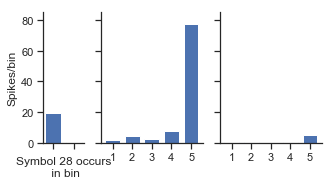

In [26]:
# HISTOGRAM (Occurence of symbol, Symbol in position, Any symbol in position)
# EPISODES WITH IDENTITY

# Figure 4F, left panel
neuron_i = 36 # Selective for: Pos  x Symbol
sym = 28

# Figure 4E, left panel
# neuron_i = 38 # Selective for: Task x Pos x Symbol
# sym = 6 

# Symbol occurs or not
ind_sym = (episodes == sym)
tmp = spike_counts[:, :, :, neuron_i]
tmp_index = np.logical_and(ind_sym, id_ep[:, :, :, neuron_i])
sym_inside = tmp[tmp_index]

ind_not_sym = (episodes != sym)
tmp = spike_counts[:, :, :, neuron_i]
tmp_index = np.logical_and(ind_not_sym, id_ep[:, :, :, neuron_i])
sym_not_inside = tmp[tmp_index]

# Symbol occurs in position 1 - 5
sym_pos = np.zeros((5, ))
for i in range(5):
    ind_sym_pos = (episodes[:, :, i] == sym)
    tmp = spike_counts[:, :, i, neuron_i]
    tmp_index = np.logical_and(ind_sym_pos, id_ep[:, :, i, neuron_i])
    ss = tmp[tmp_index]
    sym_pos[i] = np.mean(ss)
      
# Selective for symbol - IDENTITY
fig, axs = plt.subplots(1, 3, figsize=(5, 2.4), sharey=True, gridspec_kw={'width_ratios': [2/5, 1, 1]})
# fig.suptitle('Neuron {}, selective for symbol {} - duplication episodes'.format(neuron_i, sym), y=1.02)

ax = axs[0]
# ax.set_title('Occurence of symbol {}'.format(sym))
ax.bar(x=[1, 2], height=[np.mean(sym_inside), np.mean(sym_not_inside)], width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Spikes/bin')
ax.set_ylim([0, 85])
ax.set_xlabel('Symbol {} occurs\n in bin'.format(sym))
ax.set_xticks(np.arange(2) + 1)
ax.set_xticklabels(['Yes', 'No'])
ax.set_xticklabels(['', ''])

ax = axs[1]
# ax.set_title('Per step where \nsymbol {} occurs'.format(sym))
ax.bar(x=[1, 2, 3, 4, 5], height=sym_pos, width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Position')
ax.set_xticks(np.arange(5) + 1)
ax.set_xticklabels(['1', '2', '3', '4', '5'])

ax = axs[2]
# ax.set_title('Per step - avg. over \nall dupl. episodes')
all_episodes = np.mean(id_spks[:, :, neuron_i], axis=0)
ax.bar(x=[1, 2, 3, 4, 5], height=all_episodes, width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Position')
ax.set_xticks(np.arange(5) + 1)
ax.set_xticklabels(['1', '2', '3', '4', '5'])

# Save the figure and show it
# fig.savefig(os.path.join(dpath_test, 'neuron-{}-sym-{}-duplication-episodes.png'.format(neuron_i,sym)), bbox_inches='tight', dpi=175)

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5')]

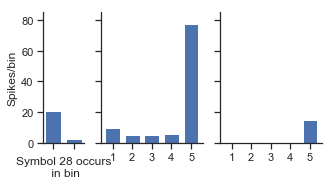

In [27]:
# HISTOGRAM (Occurence of symbol, Symbol in position, Any symbol in position)
# EPISODES WITH REVERSAL

# Figure 4F, right panel
neuron_i = 36
sym = 28

# Figure 4E, right panel
# neuron_i = 38
# sym = 6 

# Symbol occurs or not
ind_sym = (episodes == sym)
tmp = spike_counts[:, :, :, neuron_i]
tmp_index = np.logical_and(ind_sym, rev_ep[:, :, :, neuron_i])
sym_inside = tmp[tmp_index]

ind_not_sym = (episodes != sym)
tmp = spike_counts[:, :, :, neuron_i]
tmp_index = np.logical_and(ind_not_sym, rev_ep[:, :, :, neuron_i])
sym_not_inside = tmp[tmp_index]

# Symbol occurs in position 1 - 5
sym_pos = np.zeros((5, ))
for i in range(5):
    ind_sym_pos = (episodes[:, :, i] == sym)
    tmp = spike_counts[:, :, i, neuron_i]
    tmp_index = np.logical_and(ind_sym_pos, rev_ep[:, :, i, neuron_i])
    ss = tmp[tmp_index]
    sym_pos[i] = np.mean(ss)
    
# Selective for symbol - REVERSAL
fig, axs = plt.subplots(1, 3, figsize=(5, 2.4), sharey=True, gridspec_kw={'width_ratios': [2/5, 1, 1] })
# fig.suptitle('Neuron {}, selective for symbol {} - reversal episodes'.format(neuron_i, sym), y=1.02)

ax = axs[0]
# ax.set_title('Occurence of symbol {}'.format(sym))
ax.bar(x=[1, 2], height=[np.mean(sym_inside), np.mean(sym_not_inside)], width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Spikes/bin')
ax.set_ylim([0, 85])
ax.set_xlabel('Symbol {} occurs\n in bin'.format(sym))
ax.set_xticks(np.arange(2) + 1)
# ax.set_xticklabels(['Yes', 'No'])
ax.set_xticklabels(['', ''])


ax = axs[1]
# ax.set_title('Per step where \nsymbol {} occurs'.format(sym))
ax.bar(x=[1, 2, 3, 4, 5], height=sym_pos, width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Position')
ax.set_xticks(np.arange(5) + 1)
ax.set_xticklabels(['1', '2', '3', '4', '5'])

ax = axs[2]
# ax.set_title('Per step - avg. over \nall reversal episodes')
all_episodes = np.mean(rev_spks[:, :, neuron_i], axis=0)
ax.bar(x=[1, 2, 3, 4, 5], height=all_episodes, width=0.75)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlabel('Position')
ax.set_xticks(np.arange(5) + 1)
ax.set_xticklabels(['1', '2', '3', '4', '5'])

# Save the figure and show it
# fig.savefig(os.path.join(dpath_test, 'neuron-{}-sym-{}-reversal-episodes.png'.format(neuron_i,sym)), bbox_inches='tight', dpi=175)